<a href="https://colab.research.google.com/github/kopalgarg/time-series-forecasting/blob/main/time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hourly predictions of weather 

Setup - Import modules

In [113]:
import os
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

Import the weather dataset: https://www.bgc-jena.mpg.de/wetter/

14 columns including air temperature, atm pressure, humidity, and more.

In [150]:
zip_path = tf.keras.utils.get_file(
    origin= 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname = 'jena_climate_2009_2016.csv.zip',
    extract = True
)

csv_path = os.path.splitext(zip_path)[0]

Dealing with hourly predictions, so subsample data from 10 min intervals to 1 h.

In [151]:
df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


Start from index 5 and take every 6th record. Make a separate data frame for the date-time columns after reformatting it.

In [152]:
df = df[5::6]
date_time = pd.to_datetime(df.pop('Date Time'), format = '%d.%m.%Y %H:%M:%S')
date_time.head()

5    2009-01-01 01:00:00
11   2009-01-01 02:00:00
17   2009-01-01 03:00:00
23   2009-01-01 04:00:00
29   2009-01-01 05:00:00
Name: Date Time, dtype: datetime64[ns]

In [153]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Visualize features over time.

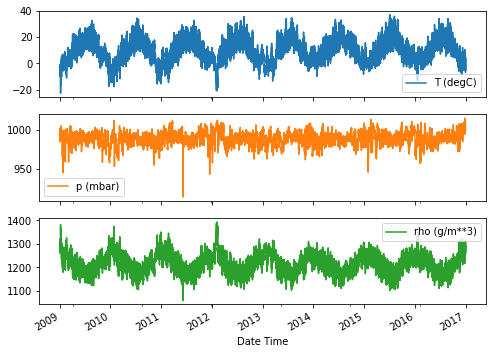

In [154]:
plot_features = df[['T (degC)', 'p (mbar)', 'rho (g/m**3)']]
plot_features.index = date_time 
p1 = plot_features.plot(subplots=True)

Zooming in

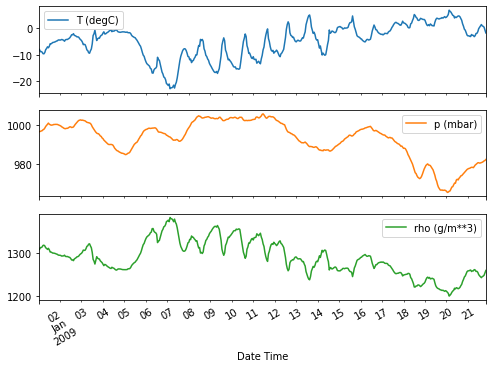

In [155]:
plot_features = df[['T (degC)', 'p (mbar)', 'rho (g/m**3)']][:500]
plot_features.index = date_time[:500]
p1 = plot_features.plot(subplots=True)

Summarize the data using mean, count, std, min, percentiles

In [156]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


Clean up (wind velocity has a negative value)

In [157]:
wv = df['wv (m/s)']
max_wv = df['max. wv (m/s)']

wv[wv==-9999.0] = 0.0
max_wv[max_wv==-9999.0] = 0.0

df['wv (m/s)'].min()
df['max. wv (m/s)'].min()

0.0

Feature engineering: 1) distribution of wind vectors

In [158]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')
wv_rad = df.pop('wd (deg)')*np.pi / 180

In [159]:
df['Wx'] = wv* np.cos(wv_rad)
df["Wy"] = wv* np.sin(wv_rad)

In [160]:
df['max Wx'] = max_wv * np.cos(wv_rad)
df['max Wy'] = max_wv * np.sin(wv_rad)

Plot the distribution of wind vectors 

Text(0, 0.5, 'Wind Y (m/s)')

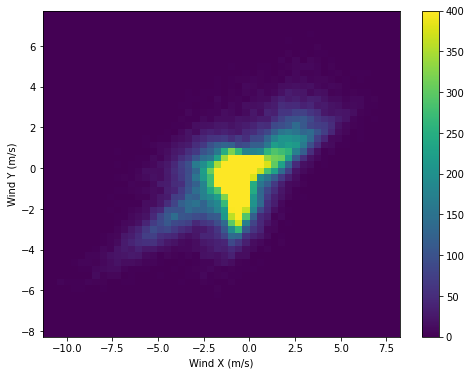

In [161]:
plt.hist2d(df['Wx'], df['Wy'], bins = (50,50), vmax = 400)
plt.colorbar()

plt.xlabel('Wind X (m/s)')
plt.ylabel('Wind Y (m/s)')

2) date time reformatting

In [162]:
date_time

5        2009-01-01 01:00:00
11       2009-01-01 02:00:00
17       2009-01-01 03:00:00
23       2009-01-01 04:00:00
29       2009-01-01 05:00:00
                 ...        
420521   2016-12-31 19:10:00
420527   2016-12-31 20:10:00
420533   2016-12-31 21:10:00
420539   2016-12-31 22:10:00
420545   2016-12-31 23:10:00
Name: Date Time, Length: 70091, dtype: datetime64[ns]

In [163]:
time_stamp = date_time.map(datetime.datetime.timestamp)
time_stamp

5         1.230772e+09
11        1.230775e+09
17        1.230779e+09
23        1.230782e+09
29        1.230786e+09
              ...     
420521    1.483211e+09
420527    1.483215e+09
420533    1.483219e+09
420539    1.483222e+09
420545    1.483226e+09
Name: Date Time, Length: 70091, dtype: float64

3) Convert to time of day and time of year signals 

In [168]:
day =  60*24*24   # sec per day
year = day* (365.2425) # sec per year 

In [169]:
df['day sin'] = np.sin(time_stamp * (2* np.pi / day))
df['day cos'] = np.cos(time_stamp * (2* np.pi / day))
df['year sin'] = np.sin(time_stamp * (2* np.pi / year))
df['year cos'] = np.cos(time_stamp * (2* np.pi / year))

In [170]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,day sin,day cos,year sin,year cos
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,-0.204862,-0.046168,-0.614587,-0.138503,-0.608761,-0.793353,-0.025121,-0.999684
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,-0.245971,-0.044701,-0.619848,-0.112645,-0.965926,-0.258819,-0.026912,-0.999638
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,-0.175527,0.039879,-0.614344,0.139576,-0.923880,0.382683,-0.028703,-0.999588
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,-0.050000,-0.086603,-0.190000,-0.329090,-0.500000,0.866025,-0.030494,-0.999535
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,-0.368202,0.156292,-0.810044,0.343843,0.130526,0.991445,-0.032285,-0.999479


Text(0.5, 0, 'Time (h)')

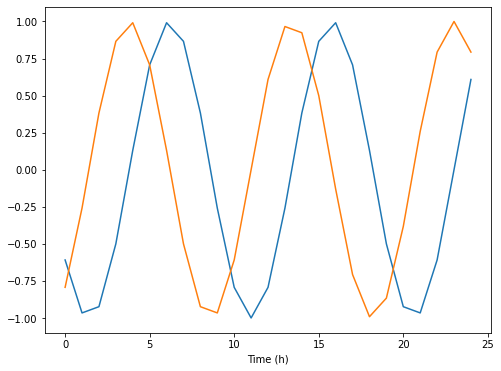

In [171]:
plt.plot(np.array(df['day sin'])[:25])
plt.plot(np.array(df['day cos'])[:25])
plt.xlabel('Time (h)')

1-dimensional discrete Fourier transform of the signal

In [173]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 365.2425*24
years_per_dataset = n_samples_h / hours_per_year
f_per_year = f_per_dataset/ years_per_dataset

years_per_dataset

7.9959433344513124

peak frequencies seen near 1/year and 1/day

([<matplotlib.axis.XTick at 0x7f04ac9e3650>,
 [Text(0, 0, '1/year'), Text(0, 0, '1/day')])

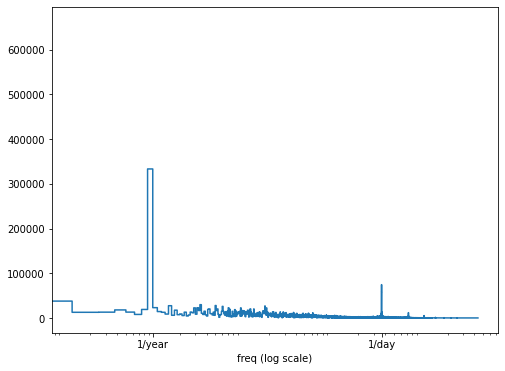

In [174]:
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.xlabel('freq (log scale)')
plt.xticks([1, 365], labels=['1/year', '1/day'])

split the date: 70%-20%-10% for training, validation and testing 

In [179]:
col_ind = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*.7)]
val_df = df[int(n*.7):int(n*.9)]
test_df = df[int(n*.9):]

num_features = df.shape[1]

Normalization: subtract mean and divide by sd

In [180]:
train_mean= train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean)/ train_std
val_df = (val_df - train_mean)/ train_std
test_df = (test_df - train_mean)/ train_std

Visualize the distribution

In [181]:
df_normalized = (df - train_mean) / train_std
df_normalized = df_normalized.melt(var_name = 'Column', 
                                   value_name = 'Normalized')
df_normalized.head()

,Column,Normalized
0,p (mbar),0.945308
1,p (mbar),0.959770
2,p (mbar),0.986284
3,p (mbar),1.004362
4,p (mbar),1.061006


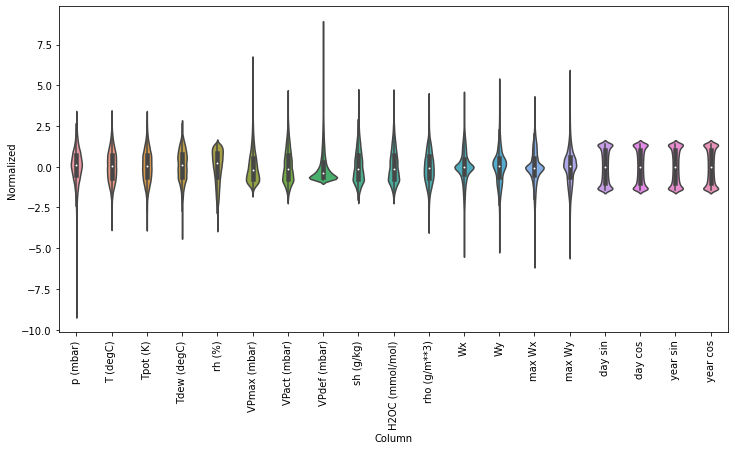

In [182]:
plt.figure(figsize=(12,6))
ax = sns.violinplot(x = 'Column',
                    y = 'Normalized',
                    data = df_normalized)
a = ax.set_xticklabels(df.keys(), rotation = 90)

Data windowing: model makes a set of predictions based on windows of consequetive samples 

In [183]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [184]:
w1 = WindowGenerator(input_width= 24, 
                     label_width= 1,
                     shift = 24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [186]:
w2 = WindowGenerator(input_width= 6, 
                     label_width= 1,
                     shift = 1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

Split

In [188]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [189]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
labels shape: (3, 1, 1)
